## Notebook to create a Hybrid Hydrological Model

**Description**

The following notebook contains the code to create, train, validate and test a Hybrid Hydrological Model 
using a LSTM network plus a process based rainfall-runoff model (SHM). The code allows for the creation of single-basin 
models, but it is conceptualized to create regional models. The code is intended as an intial introduction to the topic, 
in which we prioritized interpretability over modularity.

The logic of the code is heavily based on [Neural Hydrology](https://doi.org/10.21105/joss.04050)[1]. For a more 
flexible, robust and modular implementation of deep learning method in hydrological modeling we advice the use of Neural 
Hydrology. 

**Authors:**
- Eduardo Acuna Espinoza (eduardo.espinoza@kit.edu)
- Ralf Loritz
- Manuel Álvarez Chaves

**References:**

[1]: "F. Kratzert, M. Gauch, G. Nearing and D. Klotz: NeuralHydrology -- A Python library for Deep Learning research in hydrology. Journal of Open Source Software, 7, 4050, doi: 10.21105/joss.04050, 2022"

In [25]:
#Import necessary packages
import sys
import pandas as pd
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from typing import List, Dict, Tuple, Union, Optional

sys.path.append("../aux_functions")
from functions_datasets import CAMELS_GB as DataBase # define what you import as DataBase!
from functions_training import nse_basin_averaged
from functions_evaluation import nse
from functions_aux import create_folder, set_random_seed, write_report

Part 1. Initialize information

In [27]:
# Define experiment nae
experiment_name = 'LSTM_SHM'

# paths to access the information
path_entities = '../../data/basin_id/basins_camels_gb_669.txt'
path_data = '../../data/CAMELS_GB'

# dynamic forcings and target
dynamic_input = ['precipitation', 'peti', 'temperature']
conceptual_input = ['precipitation', 'peti', 'temperature']
target = ['discharge_spec']

# static attributes that will be used
static_input = ['area',
                'elev_mean',
                'dpsbar',
                'sand_perc',
                'silt_perc',
                'clay_perc',
                'porosity_hypres',
                'conductivity_hypres',
                'soil_depth_pelletier',
                'dwood_perc',
                'ewood_perc',
                'crop_perc',
                'urban_perc',
                'reservoir_cap',
                'p_mean',
                'pet_mean',
                'p_seasonality',
                'frac_snow',
                'high_prec_freq',
                'low_prec_freq',
                'high_prec_dur',
                'low_prec_dur']

# time periods
training_period = ['1980-10-01','1997-12-31']
validation_period = ['1975-10-01','1980-09-30']
testing_period = ['1998-01-01','2008-12-31']

network_params = {
  "input_size_lstm": len(dynamic_input) + len(static_input),
  "no_of_layers":1,  
  "seq_length": 180,
  "warmup_period": 365,
  "training_length": 365,
  "hidden_size": 64,
  "batch_size":10,
  "no_of_epochs": 20,             
  "learning_rate": 0.005,
  "adapt_learning_rate_epoch": 10,
  "adapt_gamma_learning_rate": 0.5,
  'set_forget_gate':3,
}

# device
running_device = 'cpu' #cpu or gpu

# define seed
seed = 42

# colorblind friendly palette for plotting
color_palette = {'observed': '#1f78b4','simulated': '#ff7f00'}

In [28]:
# Create folder to store the results
path_save_folder = '../results/'+experiment_name
create_folder(folder_path=path_save_folder)

Folder '../results/LSTM_SHM' already exists.


In [29]:
# check if model will be run in gpu or cpu and define device
if running_device == 'gpu':
    print(torch.cuda.get_device_name(0))
    device= f'cuda:0'
elif running_device == 'cpu':
    device = "cpu"

Part 2. Class to create the dataset object used to manage the information

In [ ]:
class BaseDataset_Hybrid(Dataset):
    """Base data set class to load and preprocess data.

    Parameters
    ----------
    dynamic_input : List[str]
        name of variables used as dynamic series input in the lstm
    static_input : List[str]
        name of static inputs used as input in the lstm (e.g. catchment attributes)
    conceptual_input: List[str]
        name of variables used as dynamic series input in the conceptual model
    target: List[str]
        target variable(s)
    sequence_length: int
        sequence length used in the LSTM
    warmup_period: int
        number of time intervals before the output of the LSTM is used in the conceptual model
    time_period: List[str]
        initial and final date (e.g. ['1987-10-01','1999-09-30']) of the time period of interest 
    path_entities: str
        path to a txt file that contain the id of the entities (e.g. catchment`s ids) that will be analyzed
    path_data: str
        path to the folder were the data is stored
    path_addional features: str
        Optional parameter. Allows the option to add any arbitrary data that is not included in the standard data sets.
        Path to a pickle file (or list of paths for multiple files), containing a dictionary with each key corresponding 
        to one basin id and the value is a date-time indexed pandas DataFrame.      
    forcing: List[str]
        For CAMELS-US dataset we should specificy which forcing data will be used (e.g. daymet, maurer, ndlas, etc.)
    check_Nan: bool
        Boolean that indicate if one should check of NaN values while processing the data
    """

    #Function to initialize the data
    def __init__(self, 
                 dynamic_input: List[str],
                 static_input: List[str],
                 conceptual_input: List[str],
                 target: List[str], 
                 sequence_length: int,
                 warmup_period: int,
                 time_period: List[str],
                 path_entities: str,
                 path_data: str,
                 path_additional_features: str = '',
                 forcings: List[str] = [],
                 check_NaN:bool = True
                 ):

        # read and create variables
        self.time_period = time_period # time period that is being considered
        self.dynamic_input = dynamic_input  # dynamic forcings going as inputs of in the lstm
        self.conceptual_input = conceptual_input 
        self.target = target  # target variable
        self.sequence_length = sequence_length # sequence length
        self.warmup_period = warmup_period # warmup period

        entities_ids = np.loadtxt(path_entities, dtype='str').tolist() 
        # save the cathments as a list even if there is just one
        self.entities_ids = [entities_ids] if isinstance(entities_ids, str) else entities_ids # catchments

        self.sequence_data = {} # store information that will be used to run the lstm
        self.df_ts = {} # store processed dataframes for all basins
        self.scaler = {} # information to standardize the data 
        self.basin_std = {} # std of the target variable of each basin (can be used later in the loss function)
        self.valid_entities= []

        # process the attributes
        self.static_input = static_input # static attributes going as inputs to the lstm
        if static_input:
            self.df_attributes = self._load_attributes(path_data)

        # process additional features that will be included in the inputs (optional) ---
        if path_additional_features:
            self.additional_features = self._load_additional_features(path_additional_features)
        
        # This loop goes through all the catchments. For each catchment in creates an entry in the dictionary
        # self.sequence_data, where we will store the information that will be sent to the lstm
        for id in self.entities_ids:
            # load time series for specific catchment id
            df_ts = self._load_data(path_data=path_data, catch_id=id, forcings = forcings)
            # add additional features (optional)
            if path_additional_features:
                df_ts = pd.concat([df_ts, self.additional_features[id]], axis=1)
            
            # Defines the start date considering the offset due to sequence length. We want that, if possible, the start
            # date is the first date of prediction.
            start_date = pd.to_datetime(self.time_period[0],format="%Y-%m-%d")
            end_date = pd.to_datetime(self.time_period[1],format="%Y-%m-%d")
            freq = pd.infer_freq(df_ts.index)
            warmup_start_date = start_date - (self.sequence_length+self.warmup_period-1)*pd.tseries.frequencies.to_offset(freq)
            
            # filter dataframe for the period and variables of interest
            keep_columns = self.dynamic_input + list(set(self.conceptual_input) - set(self.dynamic_input)) + self.target
            df_ts = df_ts.loc[warmup_start_date:end_date, keep_columns]
            
            # if all targets are Nan this basin is not considered.
            if not df_ts[self.target].isna().all().item() :
                # store dataframe
                self.df_ts[id] = df_ts
                
                # create dictionary entry for the basin
                self.sequence_data[id] = {}

                # store the information of the basin in a nested dictionary
                self.sequence_data[id]['x_d'] = torch.tensor(df_ts.loc[:, self.dynamic_input].values, 
                                                             dtype=torch.float32)
                self.sequence_data[id]['y_obs'] = torch.tensor(df_ts.loc[:, self.target].values, dtype=torch.float32)
                
                self.sequence_data[id]['x_conceptual'] = torch.tensor(df_ts.loc[:, self.conceptual_input].values, 
                                                                      dtype=torch.float32)
                if self.static_input:
                    self.sequence_data[id]['x_s'] = torch.tensor(self.df_attributes.loc[id].values, dtype=torch.float32)
                    
    def __len__(self):
        return len(self.valid_entities)
    
    def __getitem__(self, id):
        """This function is used by PyTorch's dataloader to extract the information"""
        basin, i = self.valid_entities[id]
        sample = {}

        # tensor of inputs LSTM
        x_lstm = self.sequence_data[basin]['x_d'][i, :]
        if self.static_input:
            x_s = self.sequence_data[basin]['x_s'].repeat(x_lstm.shape[0],1)
            x_lstm = torch.cat([x_lstm, x_s], dim=1)
        
        #store data
        sample['x_lstm'] = x_lstm

        # tensor of outputs
        sample['y_obs'] = self.sequence_data[basin]['y_obs'][i[self.sequence_length-1+self.warmup_period:], :]
        
        # tensor of inputs conceptual
        sample['x_conceptual'] = self.sequence_data[basin]['x_conceptual'][i[self.sequence_length-1:], :]
        
        # optional also return the basin_std
        if self.basin_std:
            sample['basin_std'] = self.basin_std[basin].repeat(sample['y_obs'].size(0)).unsqueeze(1)

        sample['basin'] = basin
        return sample
        

    def _load_attributes(self, path_data: str) -> pd.DataFrame:
        """Call the specific function that reads the static attributes information.
        
        Parameters
        ----------
        path_data : str
            path to the folder were the data is stored
            
        Returns
        -------
        df_attributes: pd.DataFrame
            Dataframe containing the attributes of interest for the catchments of interest
        """
        df_attributes = DataBase.read_attributes(path_data=path_data)
        df_attributes = df_attributes.loc[self.entities_ids, self.static_input]
        return df_attributes

    def _load_data(self, path_data: str, catch_id:str, forcings:List[str]) -> pd.DataFrame:
        """Call the specific function that reads a specific catchment timeseries into a dataframe.

        Parameters
        ----------
        path_data : str
            path to the folder were the data is stored.
        catch_id : str
            basin_id.
        forcings : str
            Can be e.g. 'daymet' or 'nldas', etc. Must match the folder names in the 'basin_mean_forcing' directory. 

        Returns
        -------
        df: pd.DataFrame
            Dataframe with the catchments` timeseries
        """
        df_ts = DataBase.read_data(path_data=path_data, catch_id=catch_id, forcings = forcings)
        return df_ts

    def _load_additional_features(self, path_additional_features: str) -> Dict[str, pd.DataFrame]:
        """Read pickle dictionary containing additional features.

        Parameters
        ----------
        path_additional_features : str
            Path to a pickle file (or list of paths for multiple files), containing a dictionary with each key 
            corresponding to one basin id and the value is a date-time indexed pandas DataFrame.   

        Returns
        -------
        additional_features: Dict[str, pd.DataFrame]
            Dictionary where each key is a basin and each value is a date-time indexed pandas DataFrame with the 
            additional features
        """
        
        with open(path_additional_features, "rb") as file:
            additional_features = pickle.load(file)
        return additional_features
  
    def calculate_basin_std(self):
        """Fill the self.basin_std dictionary with the standard deviation of the target variables for each basin"""
        for id, data in self.sequence_data.items():
            self.basin_std[id] = torch.tensor(np.nanstd(data['y_obs'].numpy()), dtype=torch.float32)
    
    def calculate_global_statistics(self, path_save_scaler:Optional[str] = ''):
        """Fill the self.scalar dictionary 
        
        Parameters
        ----------
        path_save_scalar : str
            path to save the scaler as a pickle file 
        
        The function calculates the global mean and standard deviation of the dynamic inputs, target variables and 
        static attributes, and store the in a dictionary. It will be used later to standardize used in the LSTM. This
        function should be called only in training period. 
        """
        global_x = np.vstack([df.loc[:, self.dynamic_input].values for df in self.df_ts.values()])
        self.scaler['x_d_mean'] = torch.tensor(np.nanmean(global_x, axis=0), dtype=torch.float32)
        self.scaler['x_d_std'] = torch.tensor(np.nanstd(global_x, axis=0), dtype=torch.float32)
        del global_x

        if self.static_input:
            self.scaler['x_s_mean'] = torch.tensor(self.df_attributes.mean().values, dtype= torch.float32)
            self.scaler['x_s_std'] = torch.tensor(self.df_attributes.std().values, dtype= torch.float32)

        if path_save_scaler: #save the results in a pickle file
            with open(path_save_scaler+'/scaler.pickle', 'wb') as f:
                pickle.dump(self.scaler, f)
    
    def standardize_data(self):
        """Standardize the data used in the LSTM. """
        for basin in self.sequence_data.values():
            # Standardize input
            basin['x_d'] = (basin['x_d'] - self.scaler['x_d_mean']) / self.scaler['x_d_std']
            if self.static_input:
                basin['x_s'] = (basin['x_s'] - self.scaler['x_s_mean']) / self.scaler['x_s_std']

    def generate_valid_entitites(self, training_length:int=0):
        """Generate the basin-time period combinations used for running the model 

        The function generate the basin_id-time period combinations that are used to run the model. When we are in
        training, we specify a training_length. In validation and testing this parameter can be omitted, and it will
        use the whole period as a valid entity
        
        Parameters
        ----------
        training_length:int
            Number of timesteps (e.g. days) used to calculate the loss in training
        """
        for key, df in self.df_ts.items():
            if training_length >0:
                time_cuts = list(range(self.sequence_length -1 + self.warmup_period, 
                                       len(df) + 1 - training_length, 
                                       training_length))
                # Create maps
                for cut in time_cuts:
                    self.valid_entities.append([key, list(range(cut - (self.sequence_length - 1 + self.warmup_period), 
                                                                cut  + training_length))])
                    
            else:
                self.valid_entities.append([key, list(range(0, len(df)))])

In [ ]:
class SHM(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.initial_states = self._initial_states
        self.parameter_ranges = self._parameter_ranges
        self.output_size = 1

    def forward(self, x_conceptual: torch.Tensor, lstm_out: torch.Tensor) -> Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]]:
        """Perform a forward pass on the SHM model. In this forward pass, all elements of the batch are processed in  parallel

        Parameters
        ----------
        x_conceptual: torch.Tensor
            Tensor of size [batch_size, time_steps, n_inputs]. The batch_size is associated with a certain basin and a
            certain prediction period. The time_steps refer to the number of time steps (e.g. days) that our conceptual
            model is going to be run for. The n_inputs refer to the dynamic forcings used to run the conceptual model
            (e.g. Precipitation, Temperature...)

        lstm_out: torch.Tensor
            Tensor of size [batch_size, time_steps, n_parameters]. The tensor comes from the data-driven model  and will
            be used to obtained the dynamic parameterization of the conceptual model

        Returns
        -------
        Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]]
            - y_hat: torch.Tensor
                Simulated outflow
            - parameters: Dict[str, torch.Tensor]
                Dynamic parameterization of the conceptual model
            - internal_states: Dict[str, torch.Tensor]]
                Time-evolution of the internal states of the conceptual model

        """
        # get model parameters
        parameters = self._get_dynamic_parameters_conceptual(lstm_out=lstm_out)

        # initialize structures to store the information
        states, out = self._initialize_information(conceptual_inputs=x_conceptual)

        # initialize constants
        zero = torch.tensor(0.0, dtype=torch.float32, device=x_conceptual.device)
        one = torch.tensor(1.0, dtype=torch.float32, device=x_conceptual.device)
        klu = torch.tensor(0.90, requires_grad=False, dtype=torch.float32, device=x_conceptual.device)  # land use correction factor [-]

        # auxiliary vectors to accelerate the execution of the hydrological model
        temp_mask = x_conceptual[:,:,2]<0
        snow_melt = x_conceptual[:,:,2] * parameters['dd']
        snow_melt[temp_mask] = zero
        # liquid precipitation
        liquid_p = x_conceptual[:,:,0].clone()
        liquid_p[temp_mask] = zero
        # solid precipitation (snow)
        snow = x_conceptual[:,:,0].clone()
        snow[~temp_mask] = zero
        # permanent wilting point use in ET
        pwp = torch.tensor(0.8, dtype=torch.float32, device=x_conceptual.device)* parameters['sumax']  
        
        # Storages
        ss = torch.tensor(self.initial_states['ss'], dtype=torch.float32, device=x_conceptual.device).repeat(x_conceptual.shape[0])
        sf = torch.tensor(self.initial_states['sf'], dtype=torch.float32, device=x_conceptual.device).repeat(x_conceptual.shape[0])
        su = torch.tensor(self.initial_states['su'], dtype=torch.float32, device=x_conceptual.device).repeat(x_conceptual.shape[0])
        si = torch.tensor(self.initial_states['si'], dtype=torch.float32, device=x_conceptual.device).repeat(x_conceptual.shape[0])
        sb = torch.tensor(self.initial_states['sb'], dtype=torch.float32, device=x_conceptual.device).repeat(x_conceptual.shape[0])

        # run hydrological model for each time step
        for j in range(x_conceptual.shape[1]):
            # Snow module --------------------------
            qs_out = torch.minimum(ss, snow_melt[:, j])
            ss = ss - qs_out + snow[:, j]
            qsp_out = qs_out + liquid_p[:, j]

            # Split snowmelt+rainfall into inflow to fastflow reservoir and unsaturated reservoir ------
            qf_in = torch.maximum(zero, qsp_out - parameters['f_thr'][:, j])
            qu_in = torch.minimum(qsp_out, parameters['f_thr'][:, j])

            # Fastflow module ----------------------
            sf = sf + qf_in
            qf_out = sf / parameters['kf'][:, j]
            sf = sf - qf_out

            # Unsaturated zone----------------------
            psi = (su / parameters['sumax'][:, j]) ** parameters['beta'][:, j]  # [-]
            su_temp = su + qu_in * (1 - psi)
            su = torch.minimum(su_temp, parameters['sumax'][:, j])
            qu_out = qu_in * psi + torch.maximum(zero, su_temp - parameters['sumax'][:, j])  # [mm]
            # Evapotranspiration -------------------
            ktetha = su / parameters['sumax'][:, j]
            et_mask = su <= pwp[:, j]
            ktetha[~et_mask] = one
            ret = x_conceptual[:, j, 1] * klu * ktetha  # [mm]
            su = torch.maximum(zero, su - ret)  # [mm]

            # Interflow reservoir ------------------
            qi_in = qu_out * parameters['perc'][:, j] # [mm]
            si = si + qi_in  # [mm]
            qi_out = si / parameters['ki'][:, j] # [mm]
            si = si - qi_out  # [mm]

            # Baseflow reservoir -------------------
            qb_in = qu_out * (1.0 - parameters['perc'][:, j])  # [mm]
            sb = sb + qb_in  # [mm]
            qb_out = sb / parameters['kb'][:, j]  # [mm]
            sb = sb - qb_out

            # Store time evolution of the internal states
            states['ss'][:, j] = ss
            states['sf'][:, j] = sf
            states['su'][:, j] = su
            states['si'][:, j] = si
            states['sb'][:, j] = sb

            # total outflow
            out[:, j, 0] = qf_out + qi_out + qb_out  # [mm]

        return {'y_hat': out, 'parameters': parameters, 'internal_states': states}
    
    def _get_dynamic_parameters_conceptual(self, lstm_out: torch.Tensor) -> Dict[str, torch.Tensor]:
        """Map the output of the data-driven part of the predefined ranges of the conceptual model that is being used.

        Parameters
        ----------
        lstm_out: torch.Tensor
            Tensor of size [batch_size, time_steps, n_param] that will be mapped to the predefined ranges of the
            conceptual model parameters to act as the dynamic parameterization.

        Returns
        -------
        Dict[str, torch.Tensor]
            Dynamic parameterization of the conceptual model.
        """
        dynamic_parameters = {}
        for index, (parameter_name, parameter_range) in enumerate(self._parameter_ranges.items()):
            range_t = torch.tensor(parameter_range, dtype=torch.float32, device=lstm_out.device)
            range_t = range_t.repeat(lstm_out.shape[0], 1)  # To run all the elements of the batch in parallel
            dynamic_parameters[parameter_name] = range_t[:, :1] + torch.sigmoid(lstm_out[:, :, index]) * (range_t[:, 1:] - range_t[:, :1])

        return dynamic_parameters

    
    def _initialize_information(self, conceptual_inputs: torch.Tensor) -> Tuple[Dict[str, torch.Tensor], torch.Tensor]:
        """Initialize the structures to store the time evolution of the internal states and the outflow of the conceptual
        model

        Parameters
        ----------
        conceptual_inputs: torch.Tensor
            Inputs of the conceptual model (dynamic forcings)

        Returns
        -------
        Tuple[Dict[str, torch.Tensor], torch.Tensor]
            - states: Dict[str, torch.Tensor]
                Dictionary to store the time evolution of the internal states (buckets) of the conceptual model
            - q_out: torch.Tensor
                Tensor to store the outputs of the conceptual model
        """

        states = {}
        # initialize dictionary to store the evolution of the states
        for name, _ in self._initial_states.items():
            states[name] = torch.zeros((conceptual_inputs.shape[0], conceptual_inputs.shape[1]), dtype=torch.float32,
                                       device=conceptual_inputs.device)

        # initialize vectors to store the evolution of the outputs
        out = torch.zeros((conceptual_inputs.shape[0], conceptual_inputs.shape[1], self.output_size), 
                          dtype=torch.float32, device=conceptual_inputs.device)

        return states, out
 
    @property
    def _initial_states(self) -> Dict[str, float]:
        return {
            'ss'  : 0.0,
            'sf'  : 1.0,
            'su'  : 5.0,
            'si'  : 10.0,
            'sb'  : 15.0
            }
    
    @property
    def _parameter_ranges(self) -> Dict[str, List[float]]:
        return {
            'dd': [0.0, 10.0],
            'f_thr'  : [10.0,60.0],
            'sumax'  : [20.0,700.0],
            'beta'  : [1.0, 6.0],
            'perc'  : [0.0, 1.0],
            'kf'  : [1.0, 20.0],
            'ki'  : [1.0, 100.0],
            'kb'  : [10.0, 1000.0 ]
            }
    

In [ ]:
# Class to create the hybrid model. Here is where I combine the LSTM network with the hydrological model
class Hybrid_Model(nn.Module):
    def __init__(self, network_params):
        super().__init__()
        # General information for the model
        self.seq_length = network_params['seq_length']
        self.hidden_units = network_params['hidden_size']
        self.num_layers = network_params['no_of_layers']

        # conceptual model
        self.conceptual_model = torch.jit.script(SHM())

        # linear layer
        self.linear = nn.Linear(in_features=network_params['hidden_size'], 
                                out_features=len(self.conceptual_model.parameter_ranges))
        
        # lstm
        self.lstm = nn.LSTM(input_size = network_params['input_size_lstm'], 
                            hidden_size = network_params['hidden_size'], 
                            batch_first = True,
                            num_layers = network_params['no_of_layers'])
           
    def forward(self, x_lstm, x_conceptual):
        
        # Initialize hidden state with zeros
        batch_size = x_lstm.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units, requires_grad=True, dtype=torch.float32, 
                         device=x_lstm.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units, requires_grad=True, dtype=torch.float32, 
                         device=x_lstm.device)
        
        # run LSTM 
        lstm_out, _ = self.lstm(x_lstm, (h0, c0))
        
        # map lstm outputs to the dimension of the conceptual model´s parameters
        lstm_out = lstm_out[:,self.seq_length-1:,:] # sequence to sequence
        lstm_out = self.linear(lstm_out)
        
        # get predictions
        pred = self.conceptual_model(x_conceptual=x_conceptual, lstm_out=lstm_out)

        return pred

Part 3. Create the different datasets

In [ ]:
# Dataset training
training_dataset = BaseDataset_Hybrid(dynamic_input=dynamic_input,
                                      static_input=static_input,
                                      conceptual_input=conceptual_input,
                                      target=target,
                                      sequence_length=network_params['seq_length'],
                                      warmup_period=network_params['warmup_period'],
                                      time_period=training_period,
                                      path_entities=path_entities,
                                      path_data=path_data,
                                      check_NaN=False)

training_dataset.calculate_basin_std()
training_dataset.calculate_global_statistics(path_save_scaler=path_save_folder)
training_dataset.standardize_data()
training_dataset.generate_valid_entitites(training_length=network_params["training_length"])

In [ ]:
# Dataset validation
validation_dataset = BaseDataset_Hybrid(dynamic_input=dynamic_input,
                                        static_input=static_input,
                                        conceptual_input=conceptual_input,
                                        target=target,
                                        sequence_length=network_params['seq_length'],
                                        warmup_period=network_params['warmup_period'],
                                        time_period=validation_period,
                                        path_entities=path_entities,
                                        path_data=path_data,
                                        check_NaN=False)

validation_dataset.scaler = training_dataset.scaler # read the global statistics calculated in the training period
validation_dataset.standardize_data()
validation_dataset.generate_valid_entitites()

Part 4. Create the different dataloaders

In [ ]:
#Create DataLoader for training data.
train_loader = DataLoader(training_dataset, 
                          batch_size=network_params['batch_size'],
                          shuffle=True,
                          drop_last = True)

print('Batches in training: ', len(train_loader))
sample = next(iter(train_loader))
print(f'x_lstm: {sample['x_lstm'].shape} | x_conceptual: {sample['x_conceptual'].shape} | y_obs: {sample['y_obs'].shape} | basin_std: {sample['basin_std'].shape}')

In [ ]:
# DataLoader for validation data.
validation_loader = DataLoader(validation_dataset, 
                               batch_size=100,
                               shuffle=False,
                               drop_last = False)

# see if the batches are loaded correctly
print('Batches in validation: ', len(validation_loader))
sample = next(iter(validation_loader))
print(f'x_lstm: {sample['x_lstm'].shape} | x_conceptual: {sample['x_conceptual'].shape} | y_obs: {sample['y_obs'].shape}')

Part 5. Train LSTM

In [ ]:
# construct model
set_random_seed(seed=seed)
hybrid_model = Hybrid_Model(network_params).to(device)

# optimizer: Adam, learning rate, weight decay
optimizer = torch.optim.Adam(hybrid_model.parameters(),
                             lr = network_params["learning_rate"])
    
# define learning rate scheduler / multiple ways to adapt the learning rate
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size = network_params["adapt_learning_rate_epoch"],
                                            gamma = network_params["adapt_gamma_learning_rate"])

# set forget gate to 3 to ensure that the model is capable to learn long term dependencies
hybrid_model.lstm.bias_hh_l0.data[network_params['hidden_size']:2 * network_params['hidden_size']] = network_params["set_forget_gate"]

training_time = time.time()
for epoch in range(network_params["no_of_epochs"]):
    epoch_start_time = time.time()
    total_loss = []
    # Training ----------------------------------------------------------------------
    hybrid_model.train()
    for sample in train_loader: 
        if torch.any(~torch.isnan(torch.flatten(sample['y_obs']))):
            optimizer.zero_grad() # sets gradients of weigths and bias to zero
            pred = hybrid_model(x_lstm= sample['x_lstm'].to(device), 
                                x_conceptual= sample['x_conceptual'].to(device)) # forward call
            
            loss = nse_basin_averaged(y_sim = pred['y_hat'][:,training_dataset.warmup_period:], 
                                      y_obs = sample['y_obs'].to(device),
                                      per_basin_target_std = sample['basin_std'].to(device)) 

            loss.backward() # backpropagates
            torch.nn.utils.clip_grad_norm_(hybrid_model.parameters(), 1) #clip gradients
            optimizer.step() #update weights
            total_loss.append(loss.item())
            
            # remove from cuda
            torch.cuda.empty_cache()
            del sample['x_lstm'], sample['x_conceptual'], sample['y_obs'], sample['basin_std'], pred
    
    # Average loss training
    average_loss_training = np.mean(total_loss)
    
   # validation ----------------------------------------------------------------------
    hybrid_model.eval()
    validation_results={}
    for sample in validation_loader:
        pred = hybrid_model(x_lstm= sample['x_lstm'].to(device), 
                            x_conceptual= sample['x_conceptual'].to(device)) # forward call

        # join results in a dataframe and store them in a dictionary (is easier to plot later)
        for i in range(pred['y_hat'].shape[0]):
            df_ts = validation_dataset.df_ts[sample['basin'][i]].iloc[validation_dataset.sequence_length+ validation_dataset.warmup_period-1:]
            
            df_discharge = pd.DataFrame(data={'y_obs': sample['y_obs'][i,:].flatten().cpu().detach().numpy(), 
                                              'y_sim': pred['y_hat'][i, validation_dataset.warmup_period:].flatten().cpu().detach().numpy()}, 
                                                index=df_ts.index)
            
            df_discharge = pd.concat([df_ts, df_discharge], axis=1)
            df_discharge = df_discharge.filter(['y_obs', 'y_sim'])
                
            # extract internal_state (buckets) information
            internal_states = {key: value[i, validation_dataset.warmup_period:].squeeze(0).cpu().detach().numpy() for key, value in pred['internal_states'].items()}
        
            # extract parameter  information
            parameters = {key: value[i, validation_dataset.warmup_period:].squeeze(0).cpu().detach().numpy() for key, value in pred['parameters'].items()}
        
            validation_results[sample['basin'][i]] = {'discharges': df_discharge,
                                                      'internal_states': internal_states,
                                                      'parameters': parameters}
            
        # remove from cuda
        del pred, sample['x_lstm'], sample['x_conceptual']
        torch.cuda.empty_cache()       
            
        #average loss validation
        df_results = {key: value['discharges'] for key, value in validation_results.items()}
        loss_validation = nse(df_results=df_results)
         
    # save model after every epoch
    path_saved_model = path_save_folder+'/epoch_' + str(epoch+1)
    torch.save(hybrid_model.state_dict(), path_saved_model)
            
    # print epoch report
    epoch_training_time = time.time()-epoch_start_time
    LR = optimizer.param_groups[0]['lr']
    report = f'Epoch: {epoch+1:<2} | Loss training: {"%.3f "% (average_loss_training)} | NSE validation: {"%.3f "% (loss_validation)} | LR:{"%.5f "% (LR)} | Training time: {"%.1f "% (epoch_training_time)} s'
    print(report)
    # save epoch report in txt file
    write_report(file_path=path_save_folder+'/run_progress.txt', text=report)
    # modify learning rate
    scheduler.step()

# print total report
total_training_time = time.time()-training_time
report = f'Total training time: {"%.1f "% (total_training_time)} s'
print(report)
# save total report in txt file
write_report(file_path=path_save_folder+'/run_progress.txt', text=report) 

Part 6. Test LSTM

In [30]:
# In case I already trained an LSTM I can re-construct the model
#hybrid_model = Hybrid_Model(network_params).to(device)
#hybrid_model.load_state_dict(torch.load(path_save_folder + '/epoch_20', map_location=device))

<All keys matched successfully>

In [ ]:
# We can read a previously generated scaler or use the one from before
scaler = training_dataset.scaler
#with open(path_save_folder + '/scaler.pickle', 'rb') as file:
#    scaler = pickle.load(file)

# Create dataset testing
#path_entities = path_entities = '../../data/basin_id/basins_camels_gb_60.txt'
test_dataset = BaseDataset_Hybrid(dynamic_input=dynamic_input,
                                  static_input=static_input,
                                  conceptual_input=conceptual_input,
                                  target=target,
                                  sequence_length=network_params['seq_length'],
                                  warmup_period=network_params['warmup_period'],
                                  time_period=testing_period,
                                  path_entities=path_entities,
                                  path_data=path_data,
                                  check_NaN=False)

test_dataset.scaler = training_dataset.scaler # read the global statisctics calculated in the training period
test_dataset.standardize_data()
test_dataset.generate_valid_entitites()

# DataLoader testing
test_loader = DataLoader(test_dataset, 
                         batch_size=100,
                         shuffle=False,
                         drop_last = False)

# see if the batches are loaded correctly
print('Batches in testing: ', len(test_loader))
sample = next(iter(test_loader))
print(f'x_lstm: {sample['x_lstm'].shape} | x_conceptual: {sample['x_conceptual'].shape} | y_obs: {sample['y_obs'].shape}')

In [ ]:
# Testing ----------------------------------------------------------------------
hybrid_model.eval()
test_results={}
with torch.no_grad():
    for sample in test_loader:
        pred = hybrid_model(x_lstm= sample['x_lstm'].to(device), 
                            x_conceptual= sample['x_conceptual'].to(device)) # forward call

        # join results in a dataframe and store them in a dictionary (is easier to plot later)
        for i in range(pred['y_hat'].shape[0]):
            df_ts = test_dataset.df_ts[sample['basin'][i]].iloc[test_dataset.sequence_length+ test_dataset.warmup_period-1:]
            
            df_discharge = pd.DataFrame(data={'y_obs': sample['y_obs'][i,:].flatten().cpu().detach().numpy(), 
                                              'y_sim': pred['y_hat'][i,test_dataset.warmup_period:].flatten().cpu().detach().numpy()}, 
                                              index=df_ts.index)
            
            df_discharge = pd.concat([df_ts, df_discharge], axis=1)
            df_discharge = df_discharge.filter(['y_obs', 'y_sim'])
               
            # extract internal_state (buckets) information
            internal_states = {key: value[i, test_dataset.warmup_period:].squeeze(0).cpu().detach().numpy() for key, value in pred['internal_states'].items()}
        
            # extract parameter  information
            parameters = {key: value[i, test_dataset.warmup_period:].squeeze(0).cpu().detach().numpy() for key, value in pred['parameters'].items()}
        
            test_results[sample['basin'][i]] = {'discharges': df_discharge,
                                                'internal_states': internal_states,
                                                'parameters': parameters}
            
        # remove from cuda
        del pred, sample['x_lstm'], sample['x_conceptual']
        torch.cuda.empty_cache()   

# Save results as a pickle file
#with open(path_save_folder+'/test_results.pickle', 'wb') as f:
#    pickle.dump(test_results, f)

Part 7. Initial analysis

In [31]:
# In case we already ran our model
#with open(path_save_folder+'/test_results.pickle', 'rb') as f:
#    test_results = pickle.load(f)

In [32]:
# Loss testing
discharges =  {key: value['discharges'] for key, value in test_results.items()}
loss_testing = nse(df_results=discharges, average=False)
df_NSE = pd.DataFrame(data={'basin_id': test_results.keys(), 'NSE': np.round(loss_testing,3)})
df_NSE = df_NSE.set_index('basin_id')
#df_NSE.to_csv(path_save_folder+'/NSE_669.csv', index=True, header=True)

Part 8. Initial analysis of the results

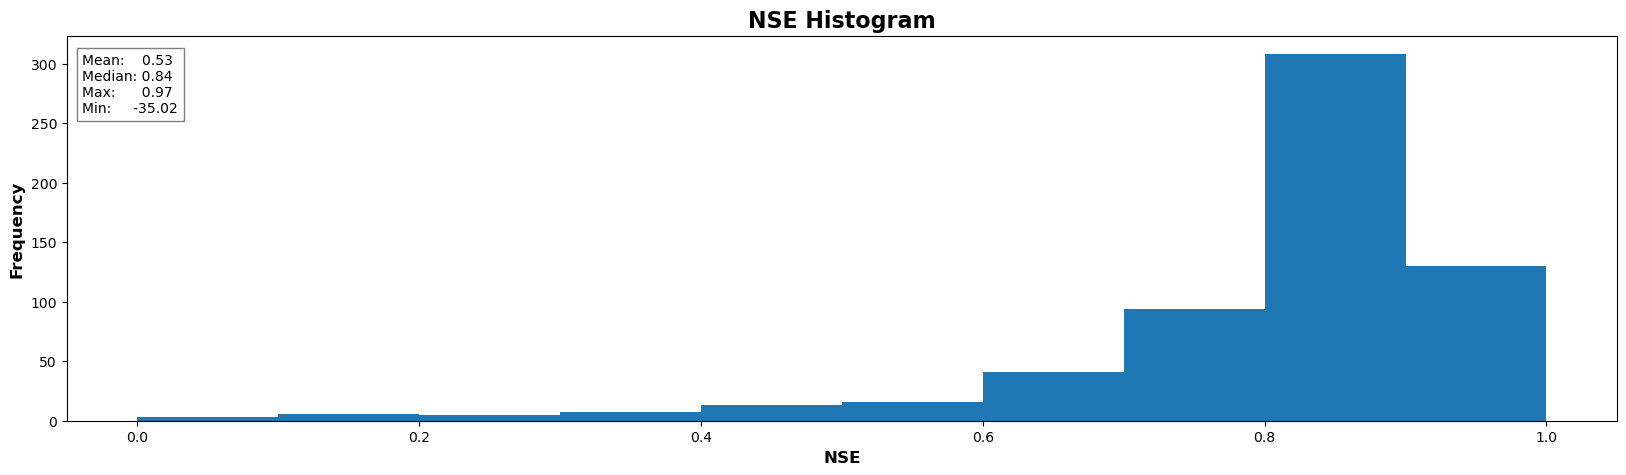

In [33]:
# Plot the histogram
plt.hist(df_NSE['NSE'], bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# Add NSE statistics to the plot
plt.text(0.01, 0.8, f'Mean: {"%.2f" % df_NSE["NSE"].mean():>7}\nMedian: {"%.2f" % df_NSE["NSE"].median():>0}\nMax: {"%.2f" % df_NSE["NSE"].max():>9}\nMin: {"%.2f" % df_NSE["NSE"].min():>10}',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel('NSE', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('NSE Histogram', fontsize=16, fontweight='bold')
plt.show()

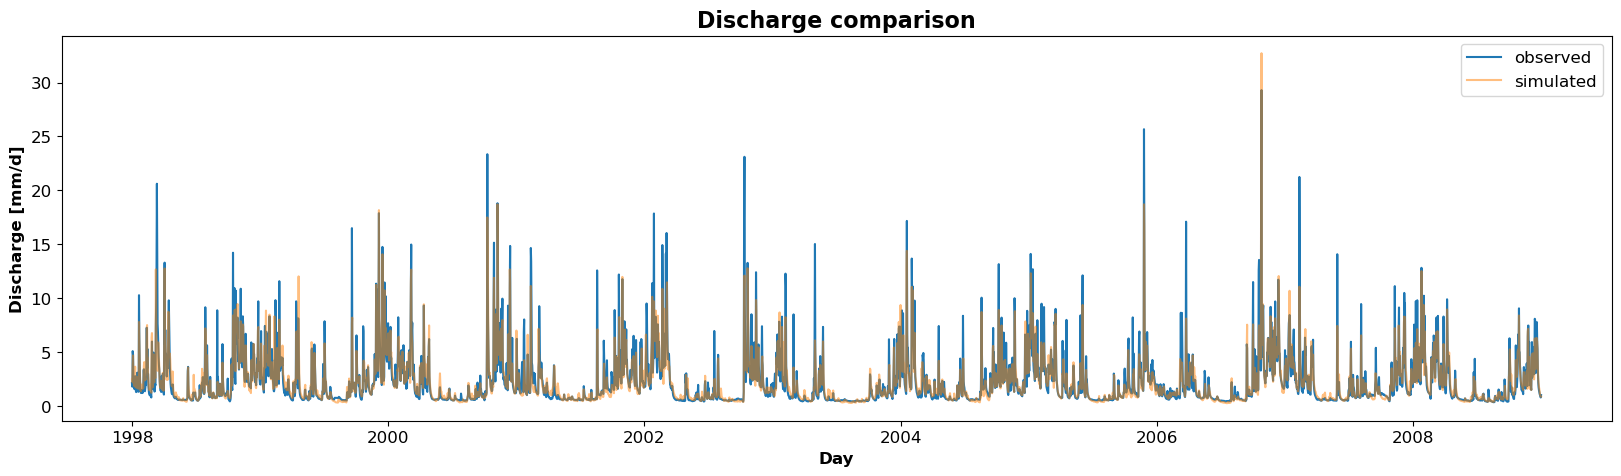

In [34]:
# Plot simulated and observed discharges
basin_to_analyze = '2001'

plt.plot(test_results[basin_to_analyze]['discharges']['y_obs'], label="observed", color=color_palette["observed"])
plt.plot(test_results[basin_to_analyze]['discharges']['y_sim'], label="simulated", alpha=0.5, color=color_palette["simulated"])

# Format plot
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('Discharge [mm/d]', fontsize=12, fontweight='bold')
plt.title('Discharge comparison', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right",fontsize=12)

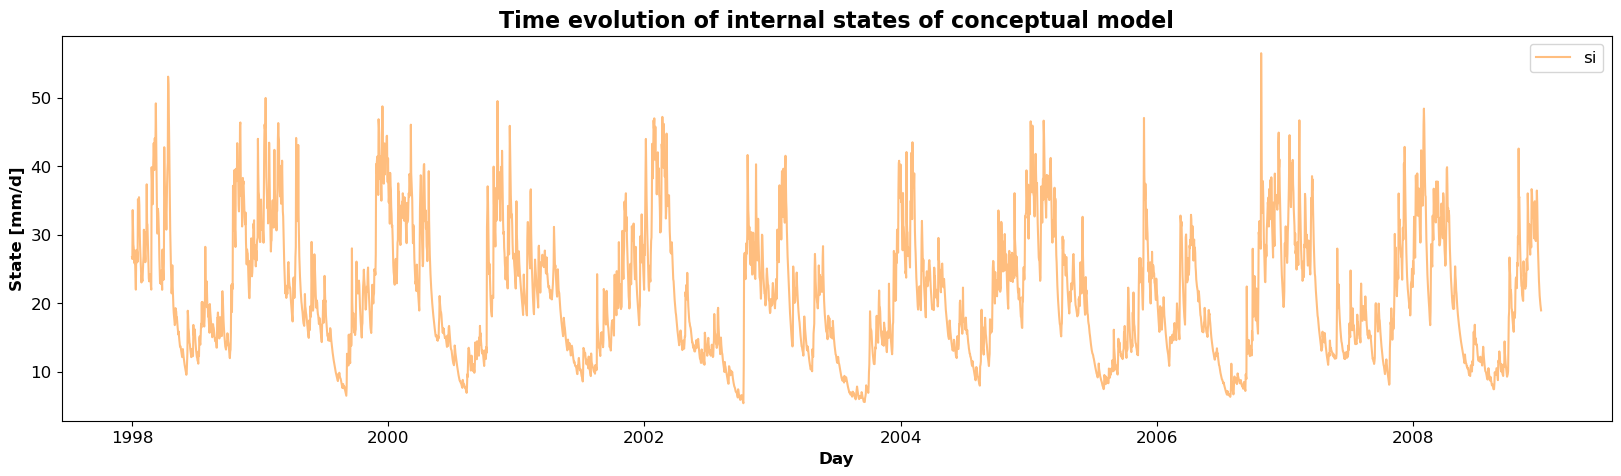

In [35]:
# Plot states
state_of_interest = 'si'

plt.plot(test_results[basin_to_analyze]['discharges']['y_obs'].index, 
         test_results[basin_to_analyze]['internal_states'][state_of_interest], 
         label=state_of_interest, color=color_palette["simulated"], alpha=0.5)

# Adding labels and legend
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('State [mm/d]', fontsize=12, fontweight='bold')
plt.title('Time evolution of internal states of conceptual model', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right",fontsize=12)
plt.show()

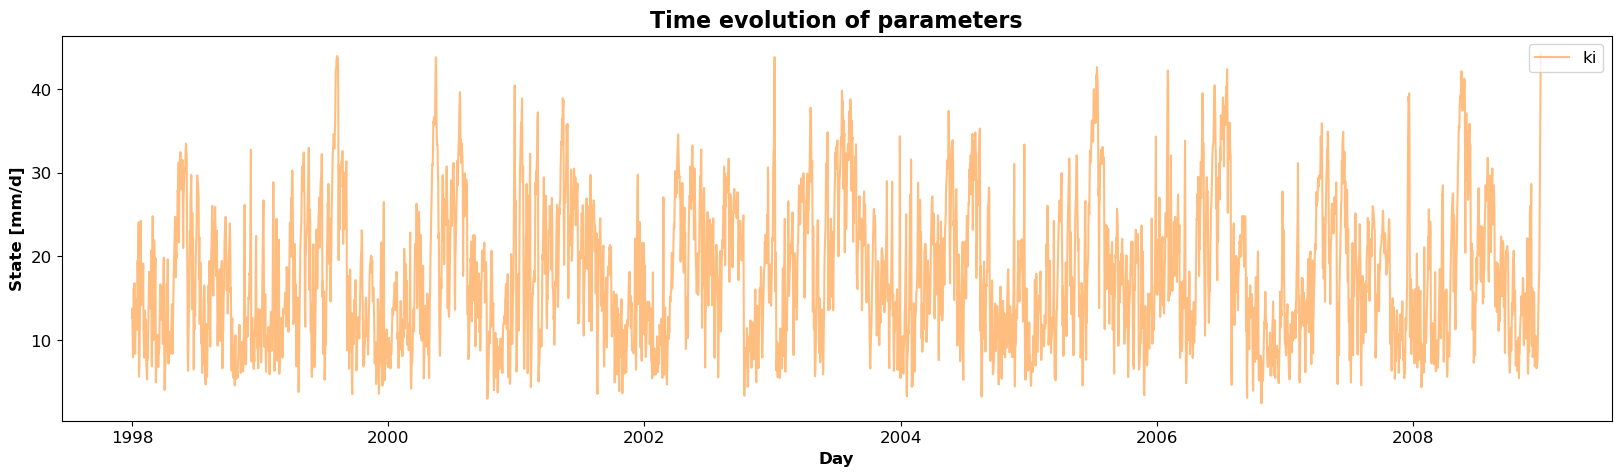

In [36]:
# Plot parameter
parameter_of_interest= 'ki'

plt.plot(test_results[basin_to_analyze]['discharges']['y_obs'].index, 
         test_results[basin_to_analyze]['parameters'][parameter_of_interest], 
         label=parameter_of_interest, color=color_palette["simulated"], alpha=0.5)

# Adding labels and legend
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('State [mm/d]', fontsize=12, fontweight='bold')
plt.title('Time evolution of parameters', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right",fontsize=12)
plt.show()